In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [2]:
#plt.rcParams["figure.figsize"] = (10, 4)
#plt.rcParams['figure.dpi'] = 200

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
nbar = [0.001, 0.01]
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8

# Mocks
nmocks = [100, 100]

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Gaussian mocks to compare to model

In [4]:
output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
name = ['{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(nmocks[i], z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

## Initialize Gaussian model

In [5]:
model = [SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nb) for nb in nbar]

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


## $P(k)$

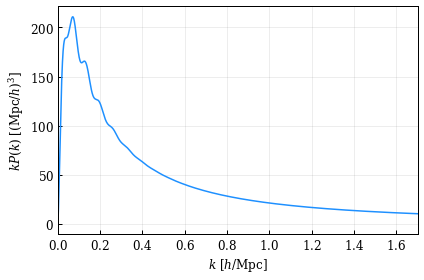

In [6]:
k = np.logspace(-3,2,1000)
plt.plot(k, k * model[1].pk(k))
plt.xlim(0, 1.7)
#plt.ylim(10, 300)
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

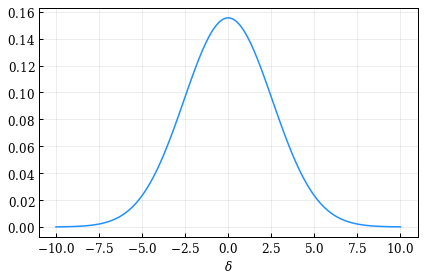

In [7]:
delta = np.linspace(-10, 10, 100)
plt.plot(delta, scipy.stats.norm.pdf(delta, 0, model[1].sigma))
plt.xlabel(r'$\delta$')
plt.show()

## $\xi(s)$

In [8]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

ells = [0]
nells = len(ells)

In [9]:
nb=0.01
xi_result = list()

for batch_index in range(10):
    batch_size = 10
    name_temp = '{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}'.format(batch_size, z, bias, boxsize, nmesh, nb, cellsize, resampler)
    batch_results = np.load(output_dir+name_temp+'_2PCF.npy', allow_pickle=True)
    for batch in batch_results:
        xi_result.append(batch)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


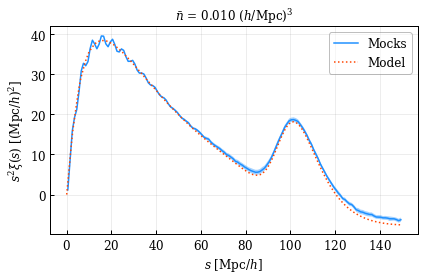

In [10]:
plt.rcParams["figure.figsize"] = (6, 4)

nb = 0.01
i=1

## Mocks
mocks_xi_ells, cov = get_poles(xi_result, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, res = xi_result[0].get_corr(return_sep=True)

## Model
model_xi = model[i].xi

for ill, ell in enumerate(ells):
    y = s**2 * mocks_xi_ells[ill]
    error = s**2 * std[ill]

    plt.plot(s, y, label='Mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    plt.fill_between(s, y-error, y+error, alpha=0.4)
    plt.plot(model[i].sep, model[i].sep**2 * model_xi, label=r'Model', ls=':')
    plt.title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig('gaussianModel_2PCF.pdf', dpi=500)
plt.show()

## $\delta_R$

In [11]:
plt.rcParams["figure.figsize"] = (10, 4)

In [12]:
nsplits = 3
randoms_size = 4
th_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf]) #scipy.stats.norm.ppf(q=[0, 1./5, 2./5, 3./5, 4./5, 1], loc=0, scale=model[0].sigma_RR)

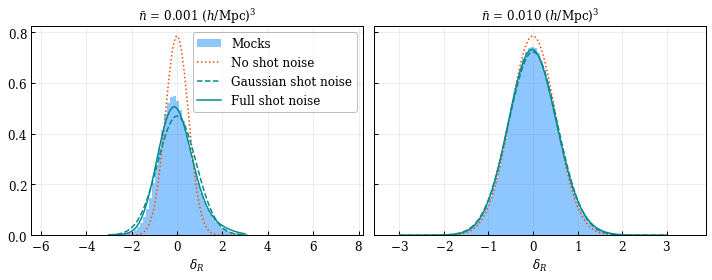

In [13]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
name_temp = ['{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(10, z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

delta = np.linspace(-3, 3, 100)

for i, nb in enumerate(nbar):
    ## Mocks
    densities = np.load(output_dir+name_temp[i]+'_delta_R.npy')
    
    ## Model
    model_density_no_shot_noise = scipy.stats.norm.pdf(delta, 0, model[i].sigma_RR)
    model_density_gaussian_shot_noise = model[i].density_with_shot_noise(delta, p=2)
    model_density_full_shot_noise = model[i].density_with_shot_noise(delta, p=4)

    axes[i].hist(np.ravel(densities), bins=100, density=True, alpha=0.5, label='Mocks')
    axes[i].plot(delta, model_density_no_shot_noise, label='No shot noise', ls=':', color='orangered')
    axes[i].plot(delta, model_density_gaussian_shot_noise, label='Gaussian shot noise', ls='--', color='darkcyan')
    axes[i].plot(delta, model_density_full_shot_noise, label='Full shot noise', ls='-', color='darkcyan')
    axes[i].set_xlabel(r'$\delta_R$')
    axes[i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
    
axes[0].legend()
plt.savefig('gaussianModelvsMocks_deltaR.pdf', dpi=500)
plt.show()

DS1
-0.7171988034695703
-0.7655735890989614
-0.0674496184257
DS2
-0.0054331170679237884
-0.0033037626352419025
0.39192132362713794
DS3
0.8269253583422154
0.862392937660966
-0.04289090782008977
DS1
-0.574330646094359
-0.578639485471994
-0.007502367158946653
DS2
-0.0011863607054678038
-0.0010446273145288793
0.11946905379257011
DS3
0.5896453970441871
0.5931402193419304
-0.005926989874359084


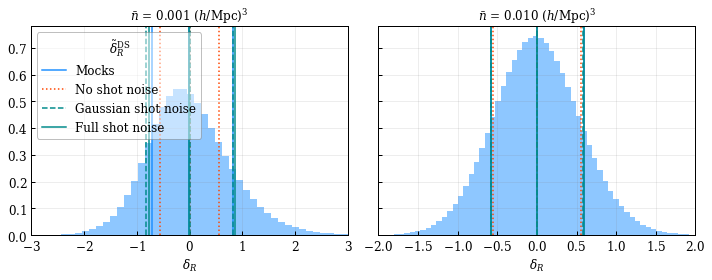

In [14]:
plt.rcParams["figure.figsize"] = (10, 4)
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
name_temp = ['{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(10, z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

delta = np.linspace(-3, 3, 100)

for i, nb in enumerate(nbar):
    ## Mocks
    densities = np.load(output_dir+name_temp[i]+'_delta_R.npy')
    
    ## Model
    model_density_no_shot_noise = scipy.stats.norm.pdf(delta, 0, model[i].sigma_RR)
    model_density_gaussian_shot_noise = model[i].density_with_shot_noise(delta, p=2)
    model_density_full_shot_noise = model[i].density_with_shot_noise(delta, p=4)

    axes[i].hist(np.ravel(densities), bins=100, density=True, alpha=0.5)
#    axes[i].plot(delta, model_density_no_shot_noise, label='No shot noise', ls=':', color='orangered')
#    axes[i].plot(delta, model_density_gaussian_shot_noise, label='Gaussian shot noise', ls='--', color='darkcyan')
#    axes[i].plot(delta, model_density_full_shot_noise, label='Full shot noise', ls='-', color='darkcyan')
    axes[i].set_xlabel(r'$\delta_R$')
    axes[i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
    
    delta_tilde_mocks = list()
    delta_tilde_model_noshotnoise = model[i].compute_delta_tilde(th_bins, shot_noise=False)
    delta_tilde_model_gaussian = model[i].compute_delta_tilde(th_bins, shot_noise=True, p=2)
    delta_tilde_model = model[i].compute_delta_tilde(th_bins, shot_noise=True)
    
    for ds in range(nsplits):
        d1 = th_bins[ds]
        d2 = th_bins[ds+1]
        split = np.logical_and((densities > d1), (densities <= d2))
        split_densities = densities[split]
        delta_tilde = np.mean(split_densities)
        delta_tilde_err = np.std(split_densities)/np.sqrt(10)

        axes[i].axvline(delta_tilde, color='dodgerblue', ls='-')
#        axes[i].fill_between(delta, 0, 1.05, where=np.logical_and(delta > delta_tilde - delta_tilde_err, delta < delta_tilde + delta_tilde_err), alpha=0.4)
        axes[i].axvline(delta_tilde_model_noshotnoise[ds], color='orangered', ls=':')
        axes[i].axvline(delta_tilde_model_gaussian[ds], color='darkcyan', ls='--')
        axes[i].axvline(delta_tilde_model[ds], color='darkcyan', ls='-')
        
        print('DS{}'.format(ds+1))
        print(delta_tilde)
        print(delta_tilde_model[ds])
        print((delta_tilde - delta_tilde_model[ds]) / delta_tilde)

axes[0].plot([], color='dodgerblue', ls='-', label='Mocks')
axes[0].plot([], color='orangered', ls=':', label='No shot noise')
axes[0].plot([], color='darkcyan', ls='--', label='Gaussian shot noise')
axes[0].plot([], color='darkcyan', ls='-', label='Full shot noise')

axes[0].legend(title=r'$\tilde{\delta}_{R}^{\mathrm{DS}}$', loc='upper left')
axes[0].set_xlim((-3, 3))
axes[1].set_xlim((-2, 2))
plt.savefig('gaussianModelvsMocks_deltaR_tilde.pdf', dpi=500)
plt.show()

In [15]:
output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'

colors = ['firebrick', 'violet', 'olivedrab']

plt.rcParams["figure.figsize"] = (10, 4)

[000349.16]  04-14 14:26  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 8000000.
[000352.26]  04-14 14:26  CatalogMesh                  INFO     Painted 4194304 out of 8000000 objects to mesh.
[000352.26]  04-14 14:26  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 8000000.
[000354.66]  04-14 14:26  CatalogMesh                  INFO     Painted 8000000 out of 8000000 objects to mesh.


/tmp/ipykernel_2756356/3968440890.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  split_weights = np.array([mock_density.data.weights[mock_density.split_indices[s]]*np.sum(mock_density.split_indices[s])/mock_density.data.size for s in range(nsplits)])


[-0.16113887  0.17361305  0.9878798 ]
[000373.05]  04-14 14:26  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 80000000.
[000375.70]  04-14 14:26  CatalogMesh                  INFO     Painted 4194304 out of 80000000 objects to mesh.
[000375.70]  04-14 14:26  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 80000000.
[000378.31]  04-14 14:26  CatalogMesh                  INFO     Painted 8388608 out of 80000000 objects to mesh.
[000378.31]  04-14 14:26  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 80000000.
[000380.94]  04-14 14:26  CatalogMesh                  INFO     Painted 12582912 out of 80000000 objects to mesh.
[000380.94]  04-14 14:26  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 80000000.
[000383.53]  04-14 14:26  CatalogMesh                  INFO     Painted 16777216 out of 80000000 objects to mesh.
[000383.53]  04-14 14:26  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 80000000.
[000386.18]  0

/tmp/ipykernel_2756356/3968440890.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  split_weights = np.array([mock_density.data.weights[mock_density.split_indices[s]]*np.sum(mock_density.split_indices[s])/mock_density.data.size for s in range(nsplits)])


[-0.00407697  0.30661475  0.69748566]


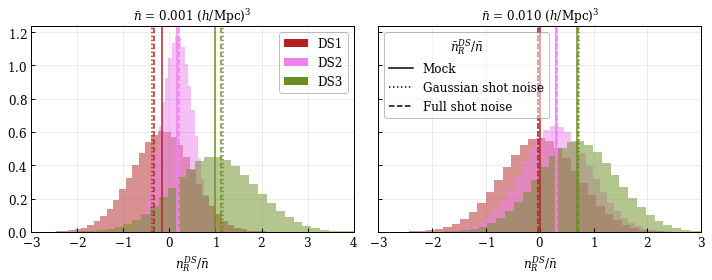

In [16]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

for i, nb in enumerate(nbar):
    name_temp = 'gaussianMock_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_mock{:d}.npy'.format(z, bias, boxsize, nmesh, nb, 0)
    mock = catalog_data.Data.load(output_dir+name_temp)
    mock_density = density_split.DensitySplit(mock)
    mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)
    mock_density.split_density(nsplits, bins=th_bins)
    nbarDS = list()

    split_weights = np.array([mock_density.data.weights[mock_density.split_indices[s]]*np.sum(mock_density.split_indices[s])/mock_density.data.size for s in range(nsplits)])
    axes[i].hist(split_weights[0], bins=50, color=colors[0], density=True, alpha=0.5)
    axes[i].hist(split_weights[1], bins=50, color=colors[1],density=True, alpha=0.5)
    axes[i].hist(split_weights[2], bins=50, color=colors[2],density=True, alpha=0.5)
    axes[i].set_xlabel(r'$n_{R}^{DS}/\bar{n}$')
    axes[i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
    nbarDS.append(np.array([np.mean(np.array(split_weights[ds])) for ds in range(nsplits)]))
    
    nbarDS_mean = np.mean(np.array(nbarDS), axis=0)
    print(nbarDS_mean)
    model_nbarDS_gaussian = model[i].nbar_R_DS(th_bins, shot_noise=True, p=2)
    model_nbarDS = model[i].nbar_R_DS(th_bins, shot_noise=True, p=4)
    
    for ds in range(nsplits):
        axes[i].axvline(np.array(model_nbarDS_gaussian)[ds], color=colors[ds], ls=':')
        axes[i].axvline(np.array(model_nbarDS)[ds], color=colors[ds], ls='--')
        axes[i].axvline(nbarDS_mean[ds], color=colors[ds], ls='-')

for ds in range(nsplits):
    axes[0].hist([], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[1].plot([], color='black', ls='-', label='Mock')
axes[1].plot([], color='black', ls=':', label='Gaussian shot noise')
axes[1].plot([], color='black', ls='--', label='Full shot noise')
axes[0].set_xlim((-3, 4))
axes[1].set_xlim((-3, 3))
axes[0].legend()
axes[1].legend(title=r'$\bar{n}_{R}^{DS}/\bar{n}$', loc='upper left')
plt.savefig('gaussianModelvsMocks_nR_DS.pdf', dpi=500)
plt.show()

## $\xi_{R}(s)$

In [17]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

In [18]:
xi_R_list = list()

for nb in nbar:
    xi_R_result = list()
    
    for batch_index in range(10):
        batch_size = 10
        name_temp = '{:d}gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}'.format(batch_size, batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler)
        batch_results = np.load(output_dir+name_temp+'_xi_R.npy', allow_pickle=True)
        for batch in batch_results:
            xi_R_result.append(batch)
    
    xi_R_list.append(xi_R_result)

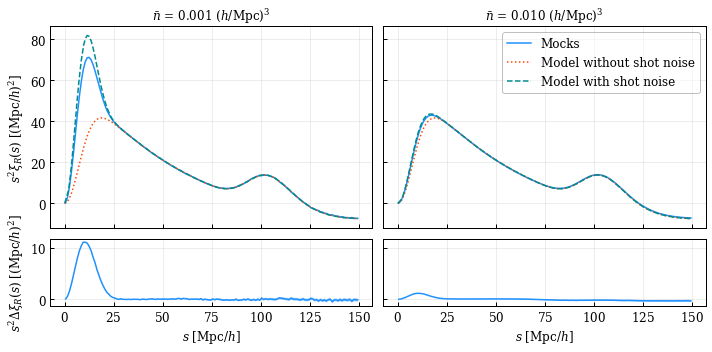

In [19]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

for i, nb in enumerate(nbar):
    ## Mocks
    #xi_R = np.load(output_dir+name[i]+'_xi_R.npy', allow_pickle=True)
    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(nmocks[i])
    s, _, res = xi_R[0].get_corr(return_sep=True)
    
    ## Model
    model_xiR_no_shot_noise = model[i].xi_R
    model_xiR_with_shot_noise = model[i].xi_R_with_shot_noise

    for ill, ell in enumerate(ells):
        y = s**2 * mocks_xi_R_ells[ill]
        error = s**2 * std[ill]
    
        axes[0][i].plot(s, y, label='Mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[0][i].fill_between(s, y-error, y+error, alpha=0.4)
        axes[0][i].plot(model[i].sep, model[i].sep**2 * model_xiR_no_shot_noise, label=r'Model without shot noise', ls=':')
        axes[0][i].plot(model[i].sep, model[i].sep**2 * model_xiR_with_shot_noise, label=r'Model with shot noise', ls='--')
        #axes[i].plot(model[i].sep, model[i].sep**2 * nb * (model_xiR_with_shot_noise + w[0] / nb * (1 + model[i].xi)) / (w[0] + nb), label=r'Model with shot noise (corrected)', ls='--')
        axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
        
        model_interp = scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].xi_R_with_shot_noise.transpose()[0])
        y_err = s**2 * (model_interp(s) - mocks_xi_R_ells[ill])
        axes[1][i].plot(s, y_err, label='Mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[1][i].fill_between(s, y_err-error, y_err+error, alpha=0.4)
        axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
axes[0][1].legend()
plt.savefig('gaussianModelvs200Mocks_xiR.pdf', dpi=500)
plt.show()

In [20]:
for i, nb in enumerate(nbar):
    for j in range(nmocks[i]):
        xi_R_list[i][j].rebin(factor=(5, 1))

    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    s, _, res = xi_R[0].get_corr(return_sep=True)
    print(s)
    s_lower_limit = 25
    s, xiell, cov = truncate_xiell(s_lower_limit, s, mocks_xi_R_ells, ells, cov)

    model_interp = scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].xi_R_with_shot_noise.transpose()[0])
    #print(np.linalg.inv(cov).dot(cov))
    diff = xiell.flatten()-model_interp(s)
    chi2 = compute_chisq(xiell.flatten(), cov/nmocks[i], model_interp(s))
    print(chi2/len(s))

[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5]
1.4905786474952265
[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5]
12.050144772300778


In [21]:
print(s)
print(len(s))

[ 27.5  32.5  37.5  42.5  47.5  52.5  57.5  62.5  67.5  72.5  77.5  82.5
  87.5  92.5  97.5 102.5 107.5 112.5 117.5 122.5 127.5 132.5 137.5 142.5
 147.5]
25


## $\xi_R^{DS}$ (randoms - tracers)

In [22]:
nsplits = 3
randoms_size = 4
th_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf])

In [23]:
results = list()

for i, nb in enumerate(nbar):
    result = list()
    
    for batch_index in range(10):
        name_temp = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
        batch_results = np.load(output_dir+name_temp+'_RH_CCF.npy', allow_pickle=True)
        for batch in batch_results:
            result.append(batch)
                
    results.append(result)
        

ValueError: operands could not be broadcast together with shapes (150,) (30,) 

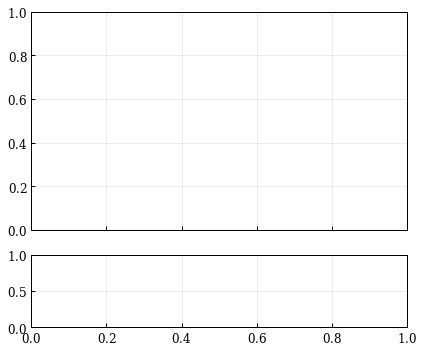

In [24]:
plt.rcParams["figure.figsize"] = (6, 5)
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i=1
nb=0.01

## Mocks
xi_R = xi_R_list[i]
mocks_xi_R_ells, cov = get_poles(xi_R, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(nmocks[i])

split_xi = results[i]
mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
s, _, res = results[i][0][0].get_corr(return_sep=True)

## Model
ccf_RH = model[i].ccf_randoms_tracers(density_bins=th_bins)

colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    y = s**2 * mocks_xi_R_ells[ill]
    error = s**2 * std[ill]

    axes[0].plot(s, y, color='dodgerblue') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    axes[0].fill_between(s, y-error, y+error, alpha=0.4, facecolor='dodgerblue')
    axes[0].plot(model[i].sep, model[i].sep**2 * model[i].xi_R, ls=':', color='dodgerblue')
    
    model_interp = scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].xi_R.transpose()[0])
    y_err = s**2 * (model_interp(s) - mocks_xi_R_ells[ill])
    axes[1].plot(s, y_err) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    axes[1].fill_between(s, y_err-error, y_err+error, alpha=0.4)

    for ds in range(nsplits):
        y = s**2 * mocks_split_xi_rh[ds][ill]
        error = s**2 * std_rh[ds][ill]

        axes[0].plot(s, y, color=colors[ds])
        axes[0].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
        axes[0].plot(model[i].sep, model[i].sep**2 * ccf_RH[ds], ls=':', color=colors[ds])
        
        model_interp = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH[ds].transpose()[0])
        y_err = s**2 * (model_interp(s) - mocks_split_xi_rh[ds][ill])
        axes[1].plot(s, y_err, ls='-', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[1].fill_between(s, y_err-error, y_err+error, alpha=0.4, facecolor=colors[ds])
 
axes[1].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
line, = axes[0].plot([], [], label=r'2PCF', color='dodgerblue')
lines.append(line)
for ds in range(nsplits):
    line, = axes[0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
line2, = axes[0].plot([], [], ls='-', color='black', label='Mocks')
line3, = axes[0].plot([], [], ls=':', color='black', label='Analytical model')

first_legend = axes[0].legend(handles=lines, loc='lower right')
ax = axes[0].add_artist(first_legend)
axes[0].legend(handles=[line2, line3], loc='upper right')

axes[0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
plt.savefig('gaussianModelvsMocks_densitysplits_nbar0.01.pdf', dpi=500)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

for i, nb in enumerate(nbar):
    ## Mocks
    split_xi = results[i]
    mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
    s, _, res = results[i][0][0].get_corr(return_sep=True)
    
    ## Model
    ccf_RH_no_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins)
    ccf_RH_gaussian_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=2)
    ccf_RH_with_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)
    
    colors = ['firebrick', 'violet', 'olivedrab']
    
    for ill, ell in enumerate(ells):
        for ds in range(nsplits):
            y = s**2 * mocks_split_xi_rh[ds][ill]
            error = s**2 * std_rh[ds][ill]

            axes[0][i].plot(s, y, color=colors[ds])
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_no_shot_noise[ds], ls=':', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_gaussian_shot_noise[ds], ls='-.', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_with_shot_noise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
            
            model_interp_gaussian_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH_gaussian_shot_noise[ds].transpose()[0])
            y_err_gaussian_shot_noise = s**2 * (model_interp_gaussian_shot_noise(s) - mocks_split_xi_rh[ds][ill])
            model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH_with_shot_noise[ds].transpose()[0])
            y_err_with_shot_noise = s**2 * (model_interp_with_shot_noise(s) - mocks_split_xi_rh[ds][ill])
            axes[1][i].plot(s, y_err_gaussian_shot_noise, label='Mocks', ls='-.', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_gaussian_shot_noise-error, y_err_gaussian_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s, y_err_with_shot_noise, label='Mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_with_shot_noise-error, y_err_with_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

for ds in range(nsplits):
    axes[0][0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
axes[0][1].plot([], [], ls=':', color='black', label='No shot noise')
axes[0][1].plot([], [], ls='-.', color='black', label='Gaussian shot noise')
axes[0][1].plot([], [], ls='--', color='black', label='Full shot noise')
axes[0][0].legend()
axes[0][1].legend()

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
plt.savefig('gaussianModelvsMocks_densitysplits.pdf', dpi=500)
plt.show()

In [ ]:
for i, nb in enumerate(nbar):
    split_xi = results[i]
    mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    s, _, res = split_xi[0][0].get_corr(return_sep=True)
    s_lower_limit = 25
    s, xiell, cov = truncate_xiell(s_lower_limit, s, mocks_split_xi_rh, ells, cov_rh, split=True, nsplits=nsplits)

    model_interp = np.array([scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)[j].transpose()[0]) for j in range(nsplits)])
    chi2 = compute_chisq(xiell.flatten(), cov/nmocks[i], np.array([model_interp[j](s) for j in range(nsplits)]).flatten())
    print(chi2/len(s))

### Compute each component of the model from mocks

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

name = ['10gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

for i, nb in enumerate(nbar):
    ## Mocks
    split_xi = results[i]
    mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
    
    output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
    densities = np.load(output_dir+name[i]+'_delta_R.npy')
    sigma_RR = np.std(densities)
    
    ccf_RH_with_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)
    
    colors = ['firebrick', 'violet', 'olivedrab']
    
    for ill, ell in enumerate(ells):
        for ds in range(nsplits):
            s, _, res = results[i][0][0].get_corr(return_sep=True)
            y = s**2 * mocks_split_xi_rh[ds][ill]
            error = s**2 * std_rh[ds][ill]
            
            d1 = th_bins[ds]
            d2 = th_bins[ds+1]
            split = np.logical_and((densities > d1), (densities <= d2))
            split_densities = densities[split]
            delta_tilde = np.mean(split_densities)
            split_model = mocks_xi_R_ells[ill] * delta_tilde / sigma_RR**2
            
            axes[0][i].plot(s, y, color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
            s, _, res = xi_R[0].get_corr(return_sep=True)
            axes[0][i].plot(s, s**2 * split_model, ls=':', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_with_shot_noise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
            
            model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH_with_shot_noise[ds].transpose()[0])
            y_err_with_shot_noise = s**2 * (model_interp_with_shot_noise(s) - mocks_split_xi_rh[ds][ill])
            axes[1][i].plot(s, s**2 * split_model - y, label='Mocks', ls=':', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, s**2 * split_model - y-error, s**2 * split_model - y+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s, y_err_with_shot_noise, label='Mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_with_shot_noise-error, y_err_with_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

for ds in range(nsplits):
    axes[0][0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
axes[0][1].plot([], [], ls=':', color='black', label='Model components from mocks')
axes[0][1].plot([], [], ls='--', color='black', label='Analytical model')
axes[0][0].legend()
axes[0][1].legend()

#plt.savefig('/feynman/home/dphp/mp270220/plots/gaussianModelvsMocks_denistysplits.png', dpi=1000)
plt.show()

## $\xi_R^{DS, qq}$ (quantiles - quantiles)

In [ ]:
results = list()
nb = 0.01
i = 1
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

for batch_index in range(10):
    name_temp = 'gaussianMock{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
    batch_results = np.load(output_dir+name_temp+'_RR_CCF.npy', allow_pickle=True)
    for batch in batch_results:
        results.append(batch)

In [ ]:
nsplits = 3
th_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf])

plt.rcParams["figure.figsize"] = (6, 5)
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

## Mocks
split_xi = results
mocks_split_xi_rr, cov_rr = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
std_rr = np.array_split(np.array(np.array_split(np.diag(cov_rr)**0.5, nells)), nsplits, axis=1)/np.sqrt(10)
s, _, res = results[0][0].get_corr(return_sep=True)

## Model
acf_RR_no_shot_noise = model[i].acf_randoms(th_bins)
acf_RR_with_shot_noise = model[i].acf_randoms(th_bins, shot_noise=True)

colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(3):
        y = s**2 * mocks_split_xi_rr[ds][ill]
        error = s**2 * std_rr[ds][ill]

        axes[0].plot(s, y, color=colors[ds])
        axes[0].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
        axes[0].plot(model[i].sep[1:], model[i].sep[1:]**2 * acf_RR_no_shot_noise[ds], ls=':', color=colors[ds])
        axes[0].plot(model[i].sep[1:], model[i].sep[1:]**2 * acf_RR_with_shot_noise[ds], ls='--', color=colors[ds])
        
        model_interp_no_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0][1:], acf_RR_no_shot_noise[ds].transpose()[0])
        model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0][1:], acf_RR_with_shot_noise[ds].transpose()[0])
        y_err_no_shot_noise = s[2:]**2 * (model_interp_no_shot_noise(s[2:]) - mocks_split_xi_rr[ds][ill][2:])
        y_err_with_shot_noise = s[2:]**2 * (model_interp_with_shot_noise(s[2:]) - mocks_split_xi_rr[ds][ill][2:])
        axes[1].plot(s[2:], y_err_no_shot_noise, ls=':', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[1].fill_between(s[2:], y_err_no_shot_noise-error[2:], y_err_no_shot_noise+error[2:], alpha=0.4, facecolor=colors[ds])
        axes[1].plot(s[2:], y_err_with_shot_noise, ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[1].fill_between(s[2:], y_err_with_shot_noise-error[2:], y_err_with_shot_noise+error[2:], alpha=0.4, facecolor=colors[ds])
 
axes[1].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
#line, = axes[0].plot([], [], label=r'2PCF', color='dodgerblue')
#lines.append(line)
for ds in range(nsplits):
    line, = axes[0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
line2, = axes[0].plot([], [], ls='-', color='black', label='Mocks')
line3, = axes[0].plot([], [], ls=':', color='black', label='Model without shot noise')
line4, = axes[0].plot([], [], ls='--', color='black', label='Model with shot noise')

first_legend = axes[0].legend(handles=lines, loc='center right')
ax = axes[0].add_artist(first_legend)
axes[0].legend(handles=[line2, line3, line4], loc='upper right')

axes[0].set_ylabel(r'$s^2 \xi_{R}^{\mathrm{qq}}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1].set_ylabel(r'$s^2 \Delta \xi_{R}^{\mathrm{qq}}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
plt.savefig('gaussianModelvsMocks_densitysplits_qq_nbar0.01.pdf', dpi=500)
plt.show()

## $\xi_R^{DS}$ (tracers - tracers)

In [ ]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

In [ ]:
results = list()

for i, nb in enumerate(nbar):
    result = list()

    for batch_index in range(10):
        name_temp = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
        batch_results_HH_auto = np.load(output_dir+name_temp+'_HH_autoCF.npy', allow_pickle=True)
        batch_results_HH_cross = np.load(output_dir+name_temp+'_HH_crossCF.npy', allow_pickle=True)
        batch_results_HH = [res_auto + res_cross for res_auto, res_cross in zip(batch_results_HH_auto, batch_results_HH_cross)]
        
        for batch in batch_results_HH:
            result.append(batch)
    
    results.append(result)

#name_temp = '10gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
#results_bis = np.load(output_dir+name_temp+'_HH_CCF.npy', allow_pickle=True)

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)

i = 0
nb = 0.001

split_xi = results[i]
mocks_split_xi_hh, cov_hh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
std_hh = np.array_split(np.array(np.array_split(np.diag(cov_hh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
s, _, res = results[i][0][0].get_corr(return_sep=True)

split_xi_bis = results_bis
mocks_split_xi_hh_bis, cov_hh_bis = get_split_poles(split_xi_bis, ells=ells, nsplits=nsplits)
std_hh_bis = np.array_split(np.array(np.array_split(np.diag(cov_hh_bis)**0.5, nells)), nsplits, axis=1)/np.sqrt(10)

colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        y = s**2 * mocks_split_xi_hh[ds][ill]
        error = s**2 * std_hh[ds][ill]
        
        y_bis = s**2 * mocks_split_xi_hh_bis[ds][ill]
        error_bis = s**2 * std_hh_bis[ds][ill]

        plt.plot(s, y, color=colors[ds])
        plt.fill_between(s, y-error, y+error, alpha=0.4, facecolor=colors[ds])
        
        plt.plot(s, y_bis, color=colors[ds], ls='--')
        plt.fill_between(s, y_bis-error_bis, y_bis+error_bis, alpha=0.4, facecolor=colors[ds])
        axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))

plt.plot([], color='black', label='Cross + auto (100 mocks)')
plt.plot([], color='black', ls='--', label='CCF (10 mocks)')
plt.legend()
plt.ylim(-100, 100)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]})

for i, nb in enumerate(nbar):
    ## Mocks
    split_xi = results[i]
    mocks_split_xi_hh, cov_hh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    std_hh = np.array_split(np.array(np.array_split(np.diag(cov_hh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
    s, _, res = results[i][0][0].get_corr(return_sep=True)
    
    ## Model
    ccf_HH_no_shot_noise = model[i].ccf_tracers(density_bins=th_bins)
    ccf_HH_gaussian_shot_noise = model[i].ccf_tracers(density_bins=th_bins, shot_noise=True, p=2)
    ccf_HH_with_shot_noise = model[i].ccf_tracers(density_bins=th_bins, shot_noise=True, p=4)
    
    colors = ['firebrick', 'violet', 'olivedrab']
    
    for ill, ell in enumerate(ells):
        for ds in range(1, 3):
        
            y = s**2 * mocks_split_xi_hh[ds][ill]
            error = s**2 * std_hh[ds][ill]

            axes[0][i].plot(s, y, color=colors[ds])
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, facecolor=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_HH_no_shot_noise[ds], ls=':', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_HH_gaussian_shot_noise[ds], ls='-.', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_HH_with_shot_noise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
            
            model_interp_gaussian_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_HH_gaussian_shot_noise[ds].transpose()[0])
            y_err_gaussian_shot_noise = s**2 * (model_interp_gaussian_shot_noise(s) - mocks_split_xi_hh[ds][ill])
            model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_HH_with_shot_noise[ds].transpose()[0])
            y_err_with_shot_noise = s**2 * (model_interp_with_shot_noise(s) - mocks_split_xi_hh[ds][ill])
            axes[1][i].plot(s, y_err_gaussian_shot_noise, label='Mocks', ls='-.', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_gaussian_shot_noise-error, y_err_gaussian_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s, y_err_with_shot_noise, label='Mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_with_shot_noise-error, y_err_with_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

for ds in range(1, 3):
    axes[0][0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
axes[0][1].plot([], [], ls=':', color='black', label='No shot noise')
axes[0][1].plot([], [], ls='-.', color='black', label='Gaussian shot noise')
axes[0][1].plot([], [], ls='--', color='black', label='Full shot noise')
axes[0][0].legend()
axes[0][1].legend()

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{\mathrm{hh}}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{\mathrm{hh}}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
plt.savefig('gaussianModelvsMocks_densitysplits_hh_DS2-3.pdf', dpi=500)
plt.show()

### Compute each component of the model from mocks

In [ ]:
sigma_R1 = 1.1934891290725032

In [ ]:
sigma_R2 = 0.7327530841255988

In [ ]:
sigma_R_list = [sigma_R1, sigma_R2]

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]})

name = ['10gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

for i, nb in enumerate(nbar):
    ## Mocks
    split_xi = results[i]
    mocks_split_xi_hh, cov_hh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    std_hh = np.array_split(np.array(np.array_split(np.diag(cov_hh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
    
    output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
    densities = np.load(output_dir+name[i]+'_delta_R.npy')
    sigma_RR = np.std(densities)
    sigma_R = sigma_R_list[i] #model[i].sigma_R_with_shot_noise
    
    xi = np.real(model[i].xi.transpose()[0])
    
    ccf_HH_with_shot_noise = model[i].ccf_tracers(density_bins=th_bins, shot_noise=True, p=4)
    
    colors = ['firebrick', 'violet', 'olivedrab']
    
    for ill, ell in enumerate(ells):
        for ds in range(nsplits):
            s, _, res = results[i][0][0].get_corr(return_sep=True)
            y = s**2 * mocks_split_xi_hh[ds][ill]
            error = s**2 * std_hh[ds][ill]
            
            d1 = th_bins[ds]
            d2 = th_bins[ds+1]
            split = np.logical_and((densities > d1), (densities <= d2))
            split_densities = densities[split]
            delta_tilde = np.mean(split_densities)
            delta2_tilde = np.var(split_densities) + delta_tilde**2
            
            denom = 1 + sigma_R**2 * delta_tilde / sigma_RR**2
            num = xi + mocks_xi_R_ells[ill] / sigma_RR**2 * (delta_tilde - sigma_R**2 + sigma_R**2 * delta2_tilde / sigma_RR**2)

            split_model = num / denom
            split_model_interp = scipy.interpolate.interp1d(model[0].sep.transpose()[0], split_model)
            
            axes[0][i].plot(s, y, color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
            s, _, res = xi_R[0].get_corr(return_sep=True)
            axes[0][i].plot(s, s**2 * split_model, ls=':', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_HH_with_shot_noise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
            
            model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_HH_with_shot_noise[ds].transpose()[0])
            s2, _, res = split_xi[0][0].get_corr(return_sep=True)
            y_err_with_shot_noise = s2**2 * (model_interp_with_shot_noise(s2) - mocks_split_xi_hh[ds][ill])
            s, _, res = results[i][0][0].get_corr(return_sep=True)
            axes[1][i].plot(s, s**2 * split_model_interp(s) - y, label='Mocks', ls=':', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, s**2 * split_model_interp(s) - y - error, s**2 * split_model_interp(s) - y + error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s2, y_err_with_shot_noise, label='Mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar)) 
            axes[1][i].fill_between(s2, y_err_with_shot_noise-error, y_err_with_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$')

for ds in range(nsplits):
    axes[0][0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
axes[0][1].plot([], [], ls=':', color='black', label='Model components from mocks')
axes[0][1].plot([], [], ls='--', color='black', label='Analytical model')
axes[0][0].legend()
axes[0][1].legend()

fig.align_ylabels()

#plt.savefig('/feynman/home/dphp/mp270220/plots/gaussianModelvsMocks_denistysplits.png', dpi=1000)
plt.show()

In [ ]:
def compute_mesh_delta_R(mocks, cellsize, resampler, use_rsd=False, use_weights=False):
    nmocks = len(mocks)
    mocks_densities = list()
    for i in range(nmocks):
        mock_catalog = mocks[i]
        mock_density = density_split.DensitySplit(mock_catalog)
        mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=use_rsd, use_weights=use_weights)
        densities = mock_density.density_mesh
        mocks_densities.append(densities)
    return mocks_densities

In [ ]:
mocks_list = list()
name = 'gaussianMock_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}'.format(z, bias, boxsize, nmesh, nbar[1])

for i in range(10):
    filename = name+'_mock{:d}'.format(i)
    mock = catalog_data.Data.load(output_dir+filename+'.npy')
    mocks_list.append(mock)
    
mesh_density = compute_mesh_delta_R(mocks_list, cellsize, resampler, use_rsd=False, use_weights=True)

In [ ]:
plt.hist(np.array(mesh_density).flatten(), bins=200)
plt.show()

In [ ]:
sigma_R2 = np.std(np.array(mesh_density).flatten())